In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import numpy as np
import sonnet as snt
import tensorflow as tf
import matplotlib.pyplot as plt

from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos_tf2 import models

In [4]:
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
def create_graph_dicts_tf(num_examples, num_elements_min_max):
    """
    Generate graphs for training.

    Args:
    num_examples: total number of graphs to generate
    num_elements_min_max: a 2-tuple with the minimum and maximum number of
      values allowable in a graph. The number of values for a graph is
      uniformly sampled withing this range. The upper bound is exclusive, and
      should be at least 2 more than the lower bound.

    Returns:
    inputs: contains the generated random numbers as node values.
    sort_indices: contains the sorting indices as nodes. Concretely
      inputs.nodes[sort_indices.nodes] will be a sorted array.
    ranks: the rank of each value in inputs normalized to the range [0, 1].
    """

    num_elements = tf.random.uniform(
      [num_examples],
      minval=num_elements_min_max[0],
      maxval=num_elements_min_max[1],
      dtype=tf.int32)
    inputs_graphs = []
    sort_indices_graphs = []
    ranks_graphs = []
    for i in range(num_examples):
        values = tf.random.uniform(shape=[num_elements[i]])
        sort_indices = tf.cast(
            tf.argsort(values, axis=-1), tf.float32)
        ranks = tf.cast(
            tf.argsort(sort_indices, axis=-1), tf.float32) / (
                tf.cast(num_elements[i], tf.float32) - 1.0)
        inputs_graphs.append({"nodes": values[:, None]})
        sort_indices_graphs.append({"nodes": sort_indices[:, None]})
        ranks_graphs.append({"nodes": ranks[:, None]})

    return inputs_graphs, sort_indices_graphs, ranks_graphs


def create_linked_list_target(batch_size, input_graphs):
    """
    Creates linked list targets.

    Returns a graph with the same number of nodes as `input_graph`. Each node
    contains a 2d vector with targets for a 1-class classification where only one
    node is `True`, the smallest value in the array. The vector contains two
    values: [prob_true, prob_false].
    It also contains edges connecting all nodes. These are again 2d vectors with
    softmax targets [prob_true, prob_false]. An edge is True
    if n+1 is the element immediately after n in the sorted list.

    Args:
    batch_size: batch size for the `input_graphs`.
    input_graphs: a `graphs.GraphsTuple` which contains a batch of inputs.

    Returns:
    A `graphs.GraphsTuple` with the targets, which encode the linked list.
    """

    target_graphs = []
    for i in range(batch_size):
        input_graph = utils_tf.get_graph(input_graphs, i)
        num_elements = tf.shape(input_graph.nodes)[0]
        si = tf.cast(tf.squeeze(input_graph.nodes), tf.int32)
        nodes = tf.reshape(tf.one_hot(si[:1], num_elements), (-1, 1))
        x = tf.stack((si[:-1], si[1:]))[None]
        y = tf.stack(
            (input_graph.senders, input_graph.receivers), axis=1)[:, :, None]
        edges = tf.reshape(
            tf.cast(
                tf.reduce_any(tf.reduce_all(tf.equal(x, y), axis=1), axis=1),
                tf.float32), (-1, 1))
        target_graphs.append(input_graph._replace(nodes=nodes, edges=edges))

    return utils_tf.concat(target_graphs, axis=0)


def compute_accuracy(target, output):
    """
    Calculate model accuracy.

    Returns the number of correctly predicted links and the number
    of completely solved list sorts (100% correct predictions).

    Args:
    target: A `graphs.GraphsTuple` that contains the target graph.
    output: A `graphs.GraphsTuple` that contains the output graph.

    Returns:
    correct: A `float` fraction of correctly labeled nodes/edges.
    solved: A `float` fraction of graphs that are completely correctly labeled.
    """

    tdds = utils_np.graphs_tuple_to_data_dicts(target)
    odds = utils_np.graphs_tuple_to_data_dicts(output)
    cs = []
    ss = []
    for td, od in zip(tdds, odds):
        num_elements = td["nodes"].shape[0]
        xn = np.argmax(td["nodes"], axis=-1)
        yn = np.argmax(od["nodes"], axis=-1)

        xe = np.reshape(
            np.argmax(
                np.reshape(td["edges"], (num_elements, num_elements, 2)), axis=-1),
            (-1,))
        ye = np.reshape(
            np.argmax(
                np.reshape(od["edges"], (num_elements, num_elements, 2)), axis=-1),
            (-1,))
        c = np.concatenate((xn == yn, xe == ye), axis=0)
        s = np.all(c)
        cs.append(c)
        ss.append(s)
    correct = np.mean(np.concatenate(cs, axis=0))
    solved = np.mean(np.stack(ss))

    return correct, solved


def create_data(batch_size, num_elements_min_max):
    """
    Returns graphs containing the inputs and targets for classification.

    Refer to create_data_dicts_tf and create_linked_list_target for more details.

    Args:
    batch_size: batch size for the `input_graphs`.
    num_elements_min_max: a 2-`tuple` of `int`s which define the [lower, upper)
      range of the number of elements per list.

    Returns:
    inputs: a `graphs.GraphsTuple` which contains the input list as a graph.
    targets: a `graphs.GraphsTuple` which contains the target as a graph.
    sort_indices: a `graphs.GraphsTuple` which contains the sort indices of
      the list elements a graph.
    ranks: a `graphs.GraphsTuple` which contains the ranks of the list
      elements as a graph.
  """

    inputs, sort_indices, ranks = create_graph_dicts_tf(
      batch_size, num_elements_min_max)
    inputs = utils_tf.data_dicts_to_graphs_tuple(inputs)
    sort_indices = utils_tf.data_dicts_to_graphs_tuple(sort_indices)
    ranks = utils_tf.data_dicts_to_graphs_tuple(ranks)

    inputs = utils_tf.fully_connect_graph_dynamic(inputs)
    sort_indices = utils_tf.fully_connect_graph_dynamic(sort_indices)
    ranks = utils_tf.fully_connect_graph_dynamic(ranks)

    targets = create_linked_list_target(batch_size, sort_indices)
    nodes = tf.concat((targets.nodes, 1.0 - targets.nodes), axis=1)
    edges = tf.concat((targets.edges, 1.0 - targets.edges), axis=1)
    targets = targets._replace(nodes=nodes, edges=edges)

    return inputs, targets, sort_indices, ranks


def create_loss(target, outputs):
    """
    Returns graphs containing the inputs and targets for classification.

    Refer to create_data_dicts_tf and create_linked_list_target for more details.

    Args:
    target: a `graphs.GraphsTuple` which contains the target as a graph.
    outputs: a `list` of `graphs.GraphsTuple`s which contains the model
      outputs for each processing step as graphs.

    Returns:
    A `list` of ops which are the loss for each processing step.
    """

    # if not isinstance(outputs, collections.Sequence):
    #   outputs = [outputs]
    losss = [
      tf.compat.v1.losses.softmax_cross_entropy(target.nodes, output.nodes) +
      tf.compat.v1.losses.softmax_cross_entropy(target.edges, output.edges)
      for output in outputs
    ]
    return tf.stack(losss)



def plot_linked_list(ax, graph, sort_indices):
    """
    Plot a networkx graph containing weights 
    for the linked list probability.
    """

    nd = len(graph.nodes())
    probs = np.zeros((nd, nd))
    for edge in graph.edges(data=True):
        probs[edge[0], edge[1]] = edge[2]["features"][0]
    ax.matshow(probs[sort_indices][:, sort_indices], cmap="viridis")
    ax.grid(False)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


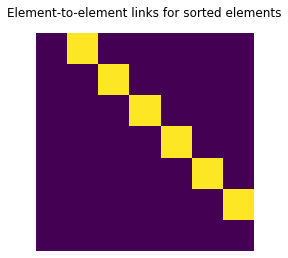

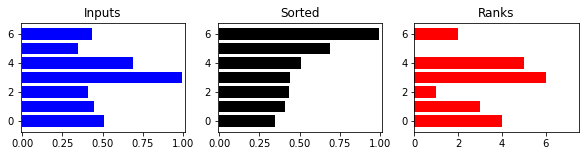

In [6]:
num_elements_min_max = (5, 10)

inputs, targets, sort_indices, ranks = create_data(
    1, num_elements_min_max)

inputs_nodes = inputs.nodes.numpy()
targets = utils_tf.nest_to_numpy(targets)
sort_indices_nodes = sort_indices.nodes.numpy()
ranks_nodes = ranks.nodes.numpy()

sort_indices = np.squeeze(sort_indices_nodes).astype(int)

# Plot sort linked lists.
# The matrix plots show each element from the sorted list (rows), and which
# element they link to as next largest (columns). Ground truth is a diagonal
# offset toward the upper-right by one.
fig = plt.figure(1, figsize=(4, 4))
fig.clf()
ax = fig.add_subplot(1, 1, 1)
plot_linked_list(ax,
                 utils_np.graphs_tuple_to_networkxs(targets)[0], sort_indices)
ax.set_title("Element-to-element links for sorted elements")
ax.set_axis_off()

fig = plt.figure(2, figsize=(10, 2))
fig.clf()
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

i = 0
num_elements = ranks_nodes.shape[0]
inputs = np.squeeze(inputs_nodes)
ranks = np.squeeze(ranks_nodes * (num_elements - 1.0)).astype(int)
x = np.arange(inputs.shape[0])

ax1.set_title("Inputs")
ax1.barh(x, inputs, color="b")
ax1.set_xlim(-0.01, 1.01)

ax2.set_title("Sorted")
ax2.barh(x, inputs[sort_indices], color="k")
ax2.set_xlim(-0.01, 1.01)

ax3.set_title("Ranks")
ax3.barh(x, ranks, color="r")
_ = ax3.set_xlim(0, len(ranks) + 0.5)

In [7]:
# The model we explore includes three components:
# - An "Encoder" graph net, which independently encodes the edge, node, and
#   global attributes (does not compute relations etc.).
# - A "Core" graph net, which performs N rounds of processing (message-passing)
#   steps. The input to the Core is the concatenation of the Encoder's output
#   and the previous output of the Core (labeled "Hidden(t)" below, where "t" is
#   the processing step).
# - A "Decoder" graph net, which independently decodes the edge, node, and
#   global attributes (does not compute relations etc.), on each
#   message-passing step.
#
#                     Hidden(t)   Hidden(t+1)
#                        |            ^
#           *---------*  |  *------*  |  *---------*
#           |         |  |  |      |  |  |         |
# Input --->| Encoder |  *->| Core |--*->| Decoder |---> Output(t)
#           |         |---->|      |     |         |
#           *---------*     *------*     *---------*
#
# The model is trained by supervised learning. Input graphs are procedurally
# generated, and output graphs have the same structure with the nodes and edges
# of the linked list labeled (using 2-element 1-hot vectors). The target
# labels the node corresponding to the lowest value in the list, and labels each
# which represents the connection between neighboring values in the sorted
# list.
#
# The training loss is computed on the output of each processing step. The
# reason for this is to encourage the model to try to solve the problem in as
# few steps as possible. It also helps make the output of intermediate steps
# more interpretable.
#
# There's no need for a separate evaluate dataset because the inputs are
# never repeated, so the training loss is the measure of performance on graphs
# from the input distribution.
#
# We also evaluate how well the models generalize to lists which are up to
# twice as large as those on which it was trained. The loss is computed only
# on the final processing step.
#
# Variables with the suffix _tr are training parameters, and variables with the
# suffix _ge are test/generalization parameters.
#
# After around 2000-5000 training iterations the model reaches near-perfect
# performance on lists with between 8-16 elements.

# Model parameters.
# Number of processing (message-passing) steps.
num_processing_steps_tr = 10
num_processing_steps_ge = 10

# Data / training parameters.
num_training_iterations = 3000
batch_size_tr = 32
batch_size_ge = 100
# Number of elements in each list is sampled uniformly from this range.
num_elements_min_max_tr = (8, 17)
num_elements_min_max_ge = (16, 33)

# Data.
@tf.function
def get_data():
    inputs_tr, targets_tr, sort_indices_tr, _ = create_data(
      batch_size_tr, num_elements_min_max_tr)
    inputs_tr = utils_tf.set_zero_edge_features(inputs_tr, 1)
    inputs_tr = utils_tf.set_zero_global_features(inputs_tr, 1)
    # Test/generalization.
    inputs_ge, targets_ge, sort_indices_ge, _ = create_data(
      batch_size_ge, num_elements_min_max_ge)
    inputs_ge = utils_tf.set_zero_edge_features(inputs_ge, 1)
    inputs_ge = utils_tf.set_zero_global_features(inputs_ge, 1)

    targets_tr = utils_tf.set_zero_global_features(targets_tr, 1)
    targets_ge = utils_tf.set_zero_global_features(targets_ge, 1)

    return inputs_tr, targets_tr, sort_indices_tr, inputs_ge, targets_ge, sort_indices_ge

# Optimizer.
learning_rate = 1e-3
optimizer = snt.optimizers.Adam(learning_rate)

model = models.EncodeProcessDecode(edge_output_size=2, node_output_size=2)
last_iteration = 0
logged_iterations = []
losses_tr = []
corrects_tr = []
solveds_tr = []
losses_ge = []
corrects_ge = []
solveds_ge = []


# Training.
def update_step(inputs_tr, targets_tr):
    with tf.GradientTape() as tape:
        outputs_tr = model(inputs_tr, num_processing_steps_tr)
        # Loss.
        loss_tr = create_loss(targets_tr, outputs_tr)
        loss_tr = tf.math.reduce_sum(loss_tr) / num_processing_steps_tr

    gradients = tape.gradient(loss_tr, model.trainable_variables)
    optimizer.apply(gradients, model.trainable_variables)
    return outputs_tr, loss_tr


In [8]:
"""
To recover the speed of TensorFlow 1, we need to use `tf.function` to
compile the update_step into a graph. However, using `tf.function` naively
may futher reduce performance as the number of nodes/edges in the batch can
change across batches, tensorflow will repeatedly trace the function multiple
times for each unique shape of the input tensors.
Instead, we obtain an explicit signature for each input argument to
`update_step` using `utils_tf.specs_from_graphs_tuple` that sets `None` sizes
for variable length axes in graph fields, preventing `tf.function` from having
to trace the function repeatedly.
"""

# Get some example data that resembles the tensors that will be fed
# into update_step():
example_input_data, example_target_data = get_data()[:2]

# Get the input signature for that function by obtaining the specs
input_signature = [
  utils_tf.specs_from_graphs_tuple(example_input_data),
  utils_tf.specs_from_graphs_tuple(example_target_data)
]

# Compile the update function using the input signature for speedy code.
compiled_update_step = tf.function(update_step, input_signature=input_signature)

In [ ]:
# You can interrupt this cell's training loop at any time, and visualize the
# intermediate results by running the next cell (below). You can then resume
# training by simply executing this cell again.

# Instantiate the model.

# How much time between logging and printing the current results.
log_every_seconds = 20

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training loss), Lge (test/generalization loss), "
      "Ctr (training fraction nodes/edges labeled correctly), "
      "Str (training fraction examples solved correctly), "
      "Cge (test/generalization fraction nodes/edges labeled correctly), "
      "Sge (test/generalization fraction examples solved correctly)")

start_time = time.time()
last_log_time = start_time
for iteration in range(last_iteration, num_training_iterations):
    last_iteration = iteration
    (inputs_tr, targets_tr, sort_indices_tr,
    inputs_ge, targets_ge, sort_indices_ge) = get_data()

    outputs_tr, loss_tr = compiled_update_step(inputs_tr, targets_tr)

    the_time = time.time()
    elapsed_since_last_log = the_time - last_log_time
    if elapsed_since_last_log > log_every_seconds:
        last_log_time = the_time
        outputs_ge = model(inputs_ge, num_processing_steps_ge)
        losss_ge = create_loss(targets_ge, outputs_ge)
        loss_ge = losss_ge[-1]

        # Replace the globals again to prevent exceptions.
        outputs_tr[-1] = outputs_tr[-1].replace(globals=None)
        targets_tr = targets_tr.replace(globals=None)

        correct_tr, solved_tr = compute_accuracy(
            utils_tf.nest_to_numpy(targets_tr),
            utils_tf.nest_to_numpy(outputs_tr[-1]))
        correct_ge, solved_ge = compute_accuracy(
            utils_tf.nest_to_numpy(targets_ge),
            utils_tf.nest_to_numpy(outputs_ge[-1]))
        elapsed = time.time() - start_time
        losses_tr.append(loss_tr.numpy())
        corrects_tr.append(correct_tr)
        solveds_tr.append(solved_tr)
        losses_ge.append(loss_ge.numpy())
        corrects_ge.append(correct_ge)
        solveds_ge.append(solved_ge)
        logged_iterations.append(iteration)
        print("# {:05d}, T {:.1f}, Ltr {:.4f}, Lge {:.4f}, Ctr {:.4f}, "
              "Str {:.4f}, Cge {:.4f}, Sge {:.4f}".format(
                  iteration, elapsed, loss_tr.numpy(), loss_ge.numpy(),
                  correct_tr, solved_tr, correct_ge, solved_ge))

In [ ]:
# This cell visualizes the results of training. You can visualize the
# intermediate results by interrupting execution of the cell above, and running
# this cell. You can then resume training by simply executing the above cell
# again.

# Plot results curves.
fig = plt.figure(11, figsize=(18, 3))
fig.clf()
x = np.array(logged_iterations)
# Loss.
y_tr = losses_tr
y_ge = losses_ge
ax = fig.add_subplot(1, 3, 1)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Loss across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Loss (binary cross-entropy)")
ax.legend()
# Correct.
y_tr = corrects_tr
y_ge = corrects_ge
ax = fig.add_subplot(1, 3, 2)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction correct across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction nodes/edges correct")
# Solved.
y_tr = solveds_tr
y_ge = solveds_ge
ax = fig.add_subplot(1, 3, 3)
ax.plot(x, y_tr, "k", label="Training")
ax.plot(x, y_ge, "k--", label="Test/generalization")
ax.set_title("Fraction solved across training")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Fraction examples solved")

# Plot sort linked lists for test/generalization.
# The matrix plots show each element from the sorted list (rows), and which
# element they link to as next largest (columns). Ground truth is a diagonal
# offset toward the upper-right by one.
outputs = utils_np.graphs_tuple_to_networkxs(outputs_tr[-1])
targets = utils_np.graphs_tuple_to_networkxs(targets_tr)
inputs = utils_np.graphs_tuple_to_networkxs(inputs_tr)
batch_element = 0
fig = plt.figure(12, figsize=(8, 4.5))
fig.clf()
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
sort_indices = np.squeeze(
    utils_np.get_graph(sort_indices_tr,
                       batch_element).nodes).astype(int)
fig.suptitle("Element-to-element link predictions for sorted elements")
plot_linked_list(ax1, targets[batch_element], sort_indices)
ax1.set_title("Ground truth")
ax1.set_axis_off()
plot_linked_list(ax2, outputs[batch_element], sort_indices)
ax2.set_title("Predicted")
ax2.set_axis_off()